In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join
from hwtmode.data import load_patch_files, min_max_scale, storm_max_value, get_meta_scalars, combine_patch_data
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tensorflow as tf
%matplotlib inline

In [7]:
config_filename = "../config/ws_mode_cnn_train_201210_hm_masked.yml"
with open(config_filename, "r") as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)

In [3]:

# Load training data
print(f"Loading training data period: {config['train_start_date']} to {config['train_end_date']}")
input = {}
output = {}
out_max = {}
labels = {}
meta = {}
meta_df = {}
input_combined = {}
input_scaled = {}
scale_values = {}
predictions = {}
modes = ["train", "val", "test"]
# Load training, validation, and testing data
for mode in modes:
    input[mode], output[mode], meta[mode] = load_patch_files(config[mode + "_start_date"],
                                                             config[mode + "_end_date"],
                                                             config["data_path"],
                                                             config["input_variables"],
                                                             config["output_variables"],
                                                             config["meta_variables"],
                                                             config["patch_radius"])
    input_combined[mode] = combine_patch_data(input[mode], config["input_variables"])
    if mode == "train":
        input_scaled[mode], scale_values[mode] = min_max_scale(input_combined[mode])
    else:
        input_scaled[mode], scale_values[mode] = min_max_scale(input_combined[mode], scale_values["train"])
    out_max[mode] = storm_max_value(output[mode][config["output_variables"][0]], meta[mode]["masks"])
    meta_df[mode] = get_meta_scalars(meta[mode])
    print(meta_df[mode].columns)
    if config["classifier"]:
        labels[mode] = np.where(out_max[mode] >= config["classifier_threshold"], 1, 0)
    else:
        labels[mode] = out_max[mode]

Loading training data period: 2010-10-01 to 2014-12-31


100%|█████████████████████| 317/317 [12:22<00:00,  2.34s/it]


REFL_COM_curr


  0%|                                | 0/73 [00:00<?, ?it/s]

['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


100%|███████████████████████| 73/73 [03:13<00:00,  2.65s/it]


REFL_COM_curr


  0%|                               | 0/237 [00:00<?, ?it/s]

['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


100%|█████████████████████| 237/237 [09:40<00:00,  2.45s/it]


REFL_COM_curr
['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


In [8]:
cnn_name = "cnn_20200504"
cnn_number = 0
mode = "train"
sal_ds = xr.open_dataarray(join(config["out_path"], f"neuron_saliency_{cnn_name}_{cnn_number:03d}_{mode}.nc"))
neuron_activations = pd.read_csv(join(config["out_path"], f"neuron_activations_{cnn_name}_{cnn_number:03d}_{mode}.csv"))
neuron_scores = pd.read_csv(join(config["out_path"], f"neuron_scores_{cnn_name}_{cnn_number:03d}.csv"))

/glade/work/ggantos/ncar_20200417/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


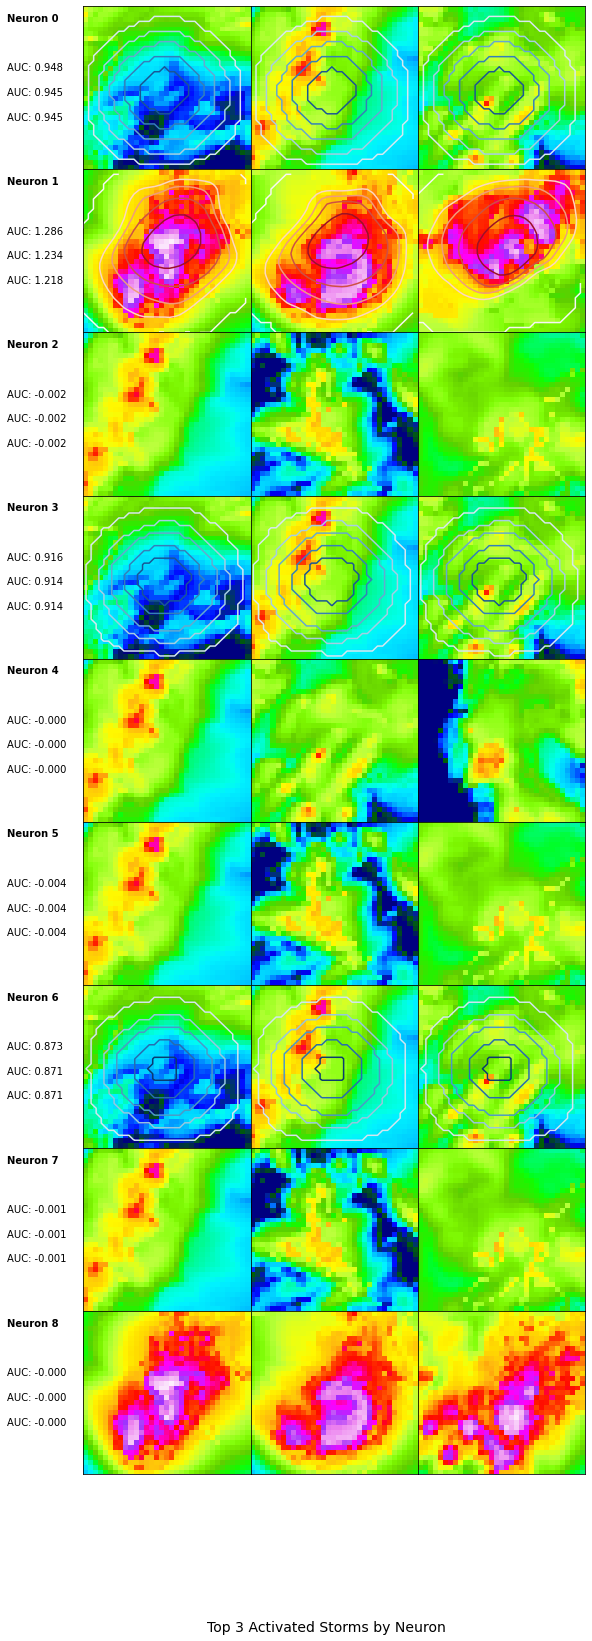

In [9]:
neurons = 9
show_top = 3
fig, axes = plt.subplots(neurons, show_top, figsize=(9, 27), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
for neuron_number in range(neurons):
    n_rank = neuron_activations[f"neuron_{neuron_number:03d}"].argsort()[::-1].values
    sal_ex = sal_ds[neuron_number, n_rank[:show_top], :, :, 0]
    sal_max = np.abs(sal_ex).max()
    for a,ax in enumerate(axes.ravel()[neuron_number*show_top:neuron_number*show_top+show_top]):
        ax.pcolormesh(input_combined[mode][n_rank[a], :, :, 0], cmap="gist_ncar", vmin=0, vmax=80)
        ax.contour(-sal_ex[a], 5, vmin=-sal_max, vmax=sal_max, cmap="RdBu_r")
        if a==0:
            ax.text(-15, 30, f"Neuron {neuron_number}", fontweight='bold')
#         ax.set_xticks(np.arange(0, 32, 8))
#         ax.set_yticks(np.arange(0, 32, 8))
#         ax.text(0, 0, meta_df[mode].loc[n_rank[a], "time"])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.text(-15-33*a, 20-5*a, f"AUC: {neuron_activations[f'neuron_{neuron_number:03d}'][n_rank[a]]:0.03f}")
fig.suptitle(f"Top {show_top} Activated Storms by Neuron", fontsize=14, y=0.05)
plt.savefig(f"cnn_{cnn_number}_top_{show_top:03d}_{mode}_hm_masked.png", dpi=200, bbox_inches="tight")
plt.show()